In [2]:
# imports
!pip install torchsde
!pip install yfinance
import os
import sys
import random
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
import torchsde
import matplotlib
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 890.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
# --- Data Preprocessing ---
def preprocess_data(df, lookback, time_step, batch_size=64, split_ratio=0.65):
    features = df[['Asset1', 'Asset2']].values  # Use only Asset1 and Asset2 as features
    targets = df['Asset2'].values  # Use Asset2 as target

    X_raw, y_raw = [], []
    for i in range(len(features) - lookback - time_step):
        X_raw.append(features[i:i+lookback])
        y_raw.append(targets[i+lookback+time_step])

    X_raw, y_raw = np.array(X_raw), np.array(y_raw).reshape(-1, 1)
    split_idx = int(split_ratio * len(X_raw))
    X_train_raw, X_test_raw = X_raw[:split_idx], X_raw[split_idx:]
    y_train_raw, y_test_raw = y_raw[:split_idx], y_raw[split_idx:]

    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()

    # Scale features and targets separately
    X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, features.shape[1])).reshape(X_train_raw.shape)
    X_test = feat_scaler.transform(X_test_raw.reshape(-1, features.shape[1])).reshape(X_test_raw.shape)

    y_train = tgt_scaler.fit_transform(y_train_raw)
    y_test = tgt_scaler.transform(y_test_raw)

    X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, feat_scaler, tgt_scaler, X_test


def load_combined_data(asset1, asset2, start, end):
    data1 = yf.download(asset1, start=start, end=end)['Close']
    data2 = yf.download(asset2, start=start, end=end)['Close']
    combined = pd.concat([data1, data2], axis=1, join='outer').dropna()
    combined.columns = ['Asset1', 'Asset2']
    return combined

In [ ]:
# --- Neural SDE with Jump Diffusion ---
class NeuralSDEWithJump(nn.Module):
    def __init__(self, hidden_size, input_features, output_size, lookback):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.lookback = lookback

        self.drift_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)
        self.diffusion_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)

        self.drift_linear = nn.Linear(hidden_size + output_size, output_size)
        self.diffusion_linear = nn.Linear(hidden_size + output_size, output_size)

        # Jump parameters (you can tune these)
        self.jump_intensity = 0.000005  # Approx. expected jump rate per dt
        self.jump_mean = 0.0       # Mean jump size
        self.jump_std = 0.05       # Stddev of jump size

        self._lstm_hidden_buffer = None

    def f(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state buffer not set. Call forward with input_sequence first.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.drift_linear(combined)

    def g(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state buffer not set. Call forward with input_sequence first.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.diffusion_linear(combined)

    def jump(self, t, y):
        # Generate jump occurrence using Bernoulli with small prob = jump_intensity * dt (assume dt=0.01)
        jump_prob = self.jump_intensity * 0.01
        jump_occurred = torch.bernoulli(torch.full_like(y, jump_prob))
        jump_noise = torch.randn_like(y) * self.jump_std + self.jump_mean
        return jump_occurred * jump_noise

    def forward(self, ts, y0, input_seq):
        # Prepare LSTM hidden state buffer
        lstm_output, (hidden, _) = self.drift_lstm(input_seq)
        self._lstm_hidden_buffer = hidden.squeeze(0)

        y = y0
        ys = [y0]
        dt = ts[1] - ts[0]

        for t in ts[1:]:
            drift = self.f(t, y)
            diffusion = self.g(t, y)
            brownian = torch.randn_like(y) * torch.sqrt(dt)
            jump = self.jump(t, y)

            y = y + drift * dt + diffusion * brownian + jump
            ys.append(y)

        ys = torch.stack(ys)
        self._lstm_hidden_buffer = None
        return ys

In [ ]:
# --- Evaluation Routine ---
def evaluate_model(model, test_loader, target_scaler, device, lookback):
    model.eval()
    actual, predicted = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            y0 = inputs[:, 0, 1].unsqueeze(1)
            ts = torch.linspace(0, 1, inputs.size(1)).to(device)
            solutions = model(ts, y0, inputs)
            preds = solutions[-1]
            actual.append(targets.squeeze().cpu().numpy())
            predicted.append(preds.squeeze().cpu().numpy())
    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    actual_orig = target_scaler.inverse_transform(actual.reshape(-1, 1))
    predicted_orig = target_scaler.inverse_transform(predicted.reshape(-1, 1))
    shifted_pred = predicted_orig[:-lookback]
    actual_aligned = actual_orig[lookback:]
    return actual_aligned, shifted_pred

In [ ]:
# --- Training Routine ---
def train_model(model, train_loader, criterion, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            y0 = inputs[:, 0, 1].unsqueeze(1)
            ts = torch.linspace(0, 1, inputs.size(1)).to(device)
            solutions = model(ts, y0, inputs)
            preds = solutions[-1]
            loss = criterion(preds, targets)
            loss.backward()
            utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
# ---------------------------- Step 1: Load Financial Data ----------------------------
start_date = '2020-01-01'
end_date = '2025-01-01'

usdt_usd = yf.download('USDT-USD', start=start_date, end=end_date)['Close'].squeeze()
rub_usd = yf.download('RUB=X', start=start_date, end=end_date)['Close'].squeeze()
usdt_cad = yf.download('USDCAD=X', start=start_date, end=end_date)['Close'].squeeze()
btc_usd = yf.download('BTC-USD', start=start_date, end=end_date)['Close'].squeeze()
oil_price = yf.download('CL=F', start=start_date, end=end_date)['Close'].squeeze()
gas_price = yf.download('NG=F', start=start_date, end=end_date)['Close'].squeeze()
interest_rate = yf.download('^IRX', start=start_date, end=end_date)['Close'].squeeze()
moex_index = yf.download('IMOEX.ME', start=start_date, end=end_date)['Close'].squeeze()

# ---------------------------- Step 2: Build DataFrame ----------------------------
data = pd.DataFrame({
    'USDT_USD': usdt_usd,
    'RUB_USD': rub_usd,
    'USDT_CAD_price': usdt_cad,
    'BTC_Price': btc_usd,
    'Oil_Price': oil_price,
    'Gas_Price': gas_price,
    'Interest_Rate': interest_rate,
    'MOEX_Index': moex_index
})

# Derived variables (customize as needed)
data['USDT_RUB_price'] = data['RUB_USD'] / data['USDT_USD']
data['BTC_USDT_ratio'] = data['BTC_Price'] / data['USDT_USD']

# ---------------------------- Step 3: Define Regression Variables ----------------------------
# ---- KEY VARIABLES TO UPDATE FOR MODEL SPECIFICATION ----
# To change endogenous, exogenous, or IVs, update these variable lists:
endogenous_var = 'USDT_RUB_price'          # <-- endogenous variable
exogenous_vars = ['Oil_Price', 'Interest_Rate']     # <-- exogenous variables
instrument_vars = ['BTC_USDT_ratio', 'USDT_CAD_price', 'Gas_Price']  # <-- instruments
outcome_var = 'MOEX_Index'                 # <-- outcome variable (what you want to predict)

# ---------------------------- Step 4: Data Preparation ----------------------------
# Drop missing data
regression_data = data.dropna(subset=instrument_vars + [endogenous_var] + exogenous_vars + [outcome_var])

# First-stage (IV) regression data
X_instruments = regression_data[instrument_vars].values
y_endogenous = regression_data[endogenous_var].values.reshape(-1, 1)

# Scale
X_instruments_scaler = MinMaxScaler()
y_endogenous_scaler = MinMaxScaler()
X_instruments_scaled = X_instruments_scaler.fit_transform(X_instruments)
y_endogenous_scaled = y_endogenous_scaler.fit_transform(y_endogenous)

# Convert to tensors (no lookback)
X_instruments_tensor = torch.tensor(X_instruments_scaled, dtype=torch.float32)
y_endogenous_tensor = torch.tensor(y_endogenous_scaled, dtype=torch.float32)

In [ ]:
# ---------------------------- Step 5: First-stage SDE ----------------------------
hidden_size = 128
output_size = 1
num_epochs = 10
batch_size = 32

first_stage_sde = NeuralSDE(hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(first_stage_sde.parameters(), lr=1e-3)

train_dataset = TensorDataset(X_instruments_tensor, y_endogenous_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        y0 = inputs[:, 0, 1].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        solutions = first_stage_sde(ts, y0, inputs)
        preds = solutions[-1]
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


# Compute residuals
first_stage_sde.eval()
with torch.no_grad():
    y0_all = X_instruments_tensor
    ts_all = torch.linspace(0, 1, 1)
    sde_outputs = first_stage_sde(ts_all, y0_all)
    y_endogenous_pred = sde_outputs[-1].numpy()
residuals = y_endogenous_scaled.squeeze() - y_endogenous_pred.squeeze()

# ---------------------------- Step 6: Second-stage SDE ----------------------------
X_exog = regression_data[exogenous_vars].values
y_outcome = regression_data[outcome_var].values.reshape(-1, 1)

X_exog_scaler = MinMaxScaler()
y_outcome_scaler = MinMaxScaler()
X_exog_scaled = X_exog_scaler.fit_transform(X_exog)
y_outcome_scaled = y_outcome_scaler.fit_transform(y_outcome)

# Augment exogenous features with first-stage residuals
X_exog_full = np.concatenate([X_exog_scaled, residuals.reshape(-1, 1)], axis=1)
X_exog_tensor = torch.tensor(X_exog_full, dtype=torch.float32)
y_outcome_tensor = torch.tensor(y_outcome_scaled, dtype=torch.float32)

train_dataset2 = TensorDataset(X_exog_tensor, y_outcome_tensor)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)

second_stage_sde = NeuralSDE(hidden_size, output_size)
optimizer2 = optim.Adam(second_stage_sde.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde.train()
    running_loss2 = 0.0
    for inputs2, targets2 in train_loader2:
        optimizer2.zero_grad()
        y0_2 = inputs2
        ts_2 = torch.linspace(0, 1, 1)
        outputs2 = second_stage_sde(ts_2, y0_2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item()
    print(f"Second-stage SDE (with residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2/len(train_loader2):.4f}")

# Train second-stage SDE without residuals (for comparison)
X_exog_tensor_nored = torch.tensor(X_exog_scaled, dtype=torch.float32)
train_dataset2_nored = TensorDataset(X_exog_tensor_nored, y_outcome_tensor)
train_loader2_nored = DataLoader(train_dataset2_nored, batch_size=batch_size, shuffle=True)
second_stage_sde_nored = NeuralSDE(hidden_size, output_size)
optimizer2_nored = optim.Adam(second_stage_sde_nored.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde_nored.train()
    running_loss2_nored = 0.0
    for inputs2, targets2 in train_loader2_nored:
        optimizer2_nored.zero_grad()
        y0_2 = inputs2
        ts_2 = torch.linspace(0, 1, 1)
        outputs2 = second_stage_sde_nored(ts_2, y0_2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2_nored.step()
        running_loss2_nored += loss2.item()
    print(f"Second-stage SDE (NO residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2_nored/len(train_loader2_nored):.4f}")

# ---------------------------- Step 7: Model Performance Comparison ----------------------------
second_stage_sde.eval()
second_stage_sde_nored.eval()
with torch.no_grad():
    y0_eval = X_exog_tensor
    ts_eval = torch.linspace(0, 1, 1)
    y_pred_with_resid = second_stage_sde(ts_eval, y0_eval)[-1].numpy()
    y_pred_with_resid = y_outcome_scaler.inverse_transform(y_pred_with_resid)
    mse_with_resid = np.mean((y_pred_with_resid - y_outcome_scaler.inverse_transform(y_outcome_scaled)) ** 2)

    y0_eval_nored = X_exog_tensor_nored
    y_pred_no_resid = second_stage_sde_nored(ts_eval, y0_eval_nored)[-1].numpy()
    y_pred_no_resid = y_outcome_scaler.inverse_transform(y_pred_no_resid)
    mse_no_resid = np.mean((y_pred_no_resid - y_outcome_scaler.inverse_transform(y_outcome_scaled)) ** 2)

print("\nNeural SDE DWH Test Results:")
print(f"Second-stage SDE MSE (with residuals): {mse_with_resid:.4f}")
print(f"Second-stage SDE MSE (NO residuals):   {mse_no_resid:.4f}")

if mse_with_resid + 1e-5 < mse_no_resid:
    print("Endogeneity detected: Including first-stage residuals improves prediction of outcome.")
else:
    print("No strong evidence of endogeneity: Including first-stage residuals does not improve prediction.")

# Plot prediction comparison
plt.figure(figsize=(12,6))
plt.plot(y_outcome_scaler.inverse_transform(y_outcome_scaled), label=f'Actual {outcome_var}')
plt.plot(y_pred_no_resid, label='Predicted (No Residuals)')
plt.plot(y_pred_with_resid, label='Predicted (With Residuals)')
plt.legend()
plt.title(f'{outcome_var} Predictions: With/Without Residuals (Neural SDE DWH)')
plt.xlabel('Time steps')
plt.ylabel(outcome_var)
plt.show()

In [ ]:
# ---------------------------- Step 8: Instrument Strength Chart (Neural SDE Analog) ----------------------------
# We estimate instrument strength in neural setting by fitting a separate NeuralSDE for each instrument and comparing MSE reduction.

f_stats = []
labels = instrument_vars
iv_colors = ['dodgerblue', 'limegreen', 'tomato', 'orange', 'purple', 'cyan']

for idx, iv in enumerate(labels):
    # Prepare single-IV data
    X_iv = regression_data[[iv]].values
    y_iv = regression_data[endogenous_var].values.reshape(-1, 1)
    scaler_X_iv = MinMaxScaler()
    scaler_y_iv = MinMaxScaler()
    X_iv_scaled = scaler_X_iv.fit_transform(X_iv)
    y_iv_scaled = scaler_y_iv.fit_transform(y_iv)

    X_iv_tensor = torch.tensor(X_iv_scaled, dtype=torch.float32)
    y_iv_tensor = torch.tensor(y_iv_scaled, dtype=torch.float32)
    train_dataset_iv = TensorDataset(X_iv_tensor, y_iv_tensor)
    train_loader_iv = DataLoader(train_dataset_iv, batch_size=batch_size, shuffle=True)

    # Fit NeuralSDE (single instrument)
    model_iv = NeuralSDE(hidden_size, output_size)
    optimizer_iv = optim.Adam(model_iv.parameters(), lr=1e-3)
    criterion_iv = nn.MSELoss()
    num_epochs_iv = 10
    for epoch in range(num_epochs_iv):
        model_iv.train()
        running_loss_iv = 0.0
        for inputs, targets in train_loader_iv:
            optimizer_iv.zero_grad()
            y0_iv = inputs
            ts_iv = torch.linspace(0, 1, 1)
            outputs_iv = model_iv(ts_iv, y0_iv)
            predictions_iv = outputs_iv[-1]
            loss_iv = criterion_iv(predictions_iv, targets)
            loss_iv.backward()
            optimizer_iv.step()
            running_loss_iv += loss_iv.item()
    # Evaluate instrument's predictive power
    model_iv.eval()
    with torch.no_grad():
        y0_eval_iv = X_iv_tensor
        ts_eval_iv = torch.linspace(0, 1, 1)
        y_pred_iv = model_iv(ts_eval_iv, y0_eval_iv)[-1].numpy()
        mse_iv = np.mean((y_pred_iv - y_iv_scaled) ** 2)
        # For a "strength" analog, we can use the reduction in variance explained by the instrument
        # Or use a pseudo-F-stat: (Variance_explained / MSE)
        var_explained = np.var(y_iv_scaled) - mse_iv
        f_stat_approx = var_explained / mse_iv if mse_iv > 0 else np.nan
        f_stats.append(float(f_stat_approx))

# Plot pseudo-F-statistics for instrument strength
plt.figure(figsize=(10, 5))
plt.bar(labels, f_stats, color=iv_colors[:len(labels)])
plt.axhline(y=1, color='black', linestyle='--', linewidth=1.2, label='Weak IV Threshold (approx. F = 1)')
for i, val in enumerate(f_stats):
    plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
plt.title(f"Instrument Strength for {endogenous_var} (NeuralSDE pseudo-F)", fontsize=14)
plt.ylabel("Pseudo-F-statistic (Variance explained / MSE)")
plt.xlabel("Instrumental Variables")
plt.legend()
plt.tight_layout()
plt.show()

# Task
Integrate the `NeuralSDEWithJump` class into the first and second-stage SDE training and evaluation steps, and review the `preprocess_data` function for suitability with the jump diffusion model.

## Review and potentially modify data preprocessing for jump diffusion

### Subtask:
Analyze the `preprocess_data` function to ensure its suitability for training a Jump Diffusion SDE model, considering the nature of jumps in financial time series data.


**Reasoning**:
Analyze the `preprocess_data` function to determine its suitability for the `NeuralSDEWithJump` model.



In [3]:
print(inspect.getsource(preprocess_data))

NameError: name 'inspect' is not defined

**Reasoning**:
Import the `inspect` module to analyze the source code of the `preprocess_data` function.



In [4]:
import inspect

print(inspect.getsource(preprocess_data))

NameError: name 'preprocess_data' is not defined

**Reasoning**:
The `preprocess_data` function is defined in a previous cell. Re-execute the cell that defines `preprocess_data` to make it available in the current environment, then display its source code for analysis.



In [5]:
# --- Data Preprocessing ---
def preprocess_data(df, lookback, time_step, batch_size=64, split_ratio=0.65):
    features = df[['Asset1', 'Asset2']].values  # Use only Asset1 and Asset2 as features
    targets = df['Asset2'].values  # Use Asset2 as target

    X_raw, y_raw = [], []
    for i in range(len(features) - lookback - time_step):
        X_raw.append(features[i:i+lookback])
        y_raw.append(targets[i+lookback+time_step])

    X_raw, y_raw = np.array(X_raw), np.array(y_raw).reshape(-1, 1)
    split_idx = int(split_ratio * len(X_raw))
    X_train_raw, X_test_raw = X_raw[:split_idx], X_raw[split_idx:]
    y_train_raw, y_test_raw = y_raw[:split_idx], y_raw[split_idx:]

    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()

    # Scale features and targets separately
    X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, features.shape[1])).reshape(X_train_raw.shape)
    X_test = feat_scaler.transform(X_test_raw.reshape(-1, features.shape[1])).reshape(X_test_raw.shape)

    y_train = tgt_scaler.fit_transform(y_train_raw)
    y_test = tgt_scaler.transform(y_test_raw)

    X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, feat_scaler, tgt_scaler, X_test

import inspect
print(inspect.getsource(preprocess_data))

def preprocess_data(df, lookback, time_step, batch_size=64, split_ratio=0.65):
    features = df[['Asset1', 'Asset2']].values  # Use only Asset1 and Asset2 as features
    targets = df['Asset2'].values  # Use Asset2 as target

    X_raw, y_raw = [], []
    for i in range(len(features) - lookback - time_step):
        X_raw.append(features[i:i+lookback])
        y_raw.append(targets[i+lookback+time_step])

    X_raw, y_raw = np.array(X_raw), np.array(y_raw).reshape(-1, 1)
    split_idx = int(split_ratio * len(X_raw))
    X_train_raw, X_test_raw = X_raw[:split_idx], X_raw[split_idx:]
    y_train_raw, y_test_raw = y_raw[:split_idx], y_raw[split_idx:]

    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()

    # Scale features and targets separately
    X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, features.shape[1])).reshape(X_train_raw.shape)
    X_test = feat_scaler.transform(X_test_raw.reshape(-1, features.shape[1])).reshape(X_test_raw.shape)

    y_train = tgt

## Integrate neuralsdewithjump into the first-stage sde

### Subtask:
Replace the `NeuralSDE` class with `NeuralSDEWithJump` in the first-stage SDE training and evaluation within the relevant code cell. This will require adapting the input data shape and potentially the training loop to align with the `NeuralSDEWithJump` forward pass which expects an `input_seq`.


**Reasoning**:
Identify the code cell for the first-stage SDE and replace NeuralSDE with NeuralSDEWithJump, adapting the input data shape and training loop to match the NeuralSDEWithJump forward pass. Also, adjust the evaluation part to use the correct input shape and extract y0.



In [6]:
# ---------------------------- Step 5: First-stage SDE ----------------------------
hidden_size = 128
# input_features for the first stage will be the number of instrumental variables
input_features_first_stage = len(instrument_vars)
output_size = 1
num_epochs = 10
batch_size = 32
# Define a lookback for the first stage - this needs to be consistent
# with how X_instruments_tensor is prepared for the NeuralSDEWithJump
lookback_first_stage = 5 # Example lookback, adjust as needed

# Prepare data with lookback for the first stage
X_raw_first_stage, y_raw_first_stage = [], []
# Ensure there are enough data points for the lookback and time_step (assuming time_step=0 for this regression-like setup)
# Using a simple loop for sequence creation
for i in range(len(X_instruments_scaled) - lookback_first_stage):
    X_raw_first_stage.append(X_instruments_scaled[i:i+lookback_first_stage])
    y_raw_first_stage.append(y_endogenous_scaled[i+lookback_first_stage]) # Target is the endogenous variable at the end of the lookback

X_first_stage_tensor = torch.tensor(np.array(X_raw_first_stage), dtype=torch.float32)
y_first_stage_tensor = torch.tensor(np.array(y_raw_first_stage), dtype=torch.float32)


# Instantiate NeuralSDEWithJump for the first stage
first_stage_sde = NeuralSDEWithJump(hidden_size, input_features_first_stage, output_size, lookback_first_stage)
criterion = nn.MSELoss()
optimizer = optim.Adam(first_stage_sde.parameters(), lr=1e-3)

train_dataset = TensorDataset(X_first_stage_tensor, y_first_stage_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
first_stage_sde.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    first_stage_sde.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        # Reshape inputs for NeuralSDEWithJump forward pass
        input_seq = inputs # inputs is already (batch_size, lookback, input_features)
        # y0 should be the target variable at the start of the sequence
        # Based on the preprocess_data function, target was Asset2, which corresponds to the endogenous variable here
        # We need to extract the first value of the endogenous variable within the lookback window
        # Assuming the last feature column in the input sequence corresponds to the endogenous variable
        y0 = input_seq[:, 0, -1].unsqueeze(1)

        ts = torch.linspace(0, 1, inputs.size(1)).to(device) # ts should match the sequence length

        solutions = first_stage_sde(ts, y0, input_seq)
        preds = solutions[-1] # Predict the value at the end of the sequence
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"First-stage SDE Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Compute residuals
first_stage_sde.eval()
with torch.no_grad():
    # Prepare full data for evaluation
    X_raw_eval_first_stage, y_raw_eval_first_stage = [], []
    for i in range(len(X_instruments_scaled) - lookback_first_stage):
        X_raw_eval_first_stage.append(X_instruments_scaled[i:i+lookback_first_stage])
        y_raw_eval_first_stage.append(y_endogenous_scaled[i+lookback_first_stage])

    X_eval_first_stage_tensor = torch.tensor(np.array(X_raw_eval_first_stage), dtype=torch.float32).to(device)
    y_eval_first_stage_tensor = torch.tensor(np.array(y_raw_eval_first_stage), dtype=torch.float32).to(device)

    eval_dataset = TensorDataset(X_eval_first_stage_tensor, y_eval_first_stage_tensor)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    y_endogenous_pred_list = []
    y_endogenous_actual_list = []

    for inputs, targets in eval_loader:
        input_seq = inputs
        y0 = input_seq[:, 0, -1].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        solutions = first_stage_sde(ts, y0, input_seq)
        preds = solutions[-1]
        y_endogenous_pred_list.append(preds.cpu().numpy())
        y_endogenous_actual_list.append(targets.cpu().numpy())

    y_endogenous_pred = np.concatenate(y_endogenous_pred_list).squeeze()
    y_endogenous_actual = np.concatenate(y_endogenous_actual_list).squeeze()


residuals = y_endogenous_actual - y_endogenous_pred

# ---------------------------- Step 6: Second-stage SDE ----------------------------
X_exog = regression_data[exogenous_vars].values
y_outcome = regression_data[outcome_var].values.reshape(-1, 1)

X_exog_scaler = MinMaxScaler()
y_outcome_scaler = MinMaxScaler()
X_exog_scaled = X_exog_scaler.fit_transform(X_exog)
y_outcome_scaled = y_outcome_scaler.fit_transform(y_outcome)

# Augment exogenous features with first-stage residuals
# Need to align residuals with the second stage data
# Assuming residuals correspond to the same time indices as the second stage data after dropping NaNs
# The length of residuals should match the length of regression_data
if len(residuals) != len(regression_data):
    # This is a potential issue if the lookback in the first stage removed data points
    # For now, we will pad the residuals or truncate the second stage data to match length
    # A more robust solution would align by index
    min_len = min(len(residuals), len(X_exog_scaled))
    residuals_aligned = residuals[:min_len]
    X_exog_scaled_aligned = X_exog_scaled[:min_len]
    y_outcome_scaled_aligned = y_outcome_scaled[:min_len]
else:
    residuals_aligned = residuals
    X_exog_scaled_aligned = X_exog_scaled
    y_outcome_scaled_aligned = y_outcome_scaled


X_exog_full = np.concatenate([X_exog_scaled_aligned, residuals_aligned.reshape(-1, 1)], axis=1)
X_exog_tensor = torch.tensor(X_exog_full, dtype=torch.float32)
y_outcome_tensor = torch.tensor(y_outcome_scaled_aligned, dtype=torch.float32)

# Define lookback and input features for the second stage
lookback_second_stage = 5 # Example lookback, adjust as needed
input_features_second_stage = X_exog_full.shape[1] # Number of exogenous vars + 1 (for residuals)

# Prepare data with lookback for the second stage
X_raw_second_stage, y_raw_second_stage = [], []
for i in range(len(X_exog_full) - lookback_second_stage):
    X_raw_second_stage.append(X_exog_full[i:i+lookback_second_stage])
    y_raw_second_stage.append(y_outcome_scaled_aligned[i+lookback_second_stage])

X_second_stage_tensor = torch.tensor(np.array(X_raw_second_stage), dtype=torch.float32)
y_second_stage_tensor = torch.tensor(np.array(y_raw_second_stage), dtype=torch.float32)


train_dataset2 = TensorDataset(X_second_stage_tensor, y_second_stage_tensor)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)

second_stage_sde = NeuralSDEWithJump(hidden_size, input_features_second_stage, output_size, lookback_second_stage).to(device)
optimizer2 = optim.Adam(second_stage_sde.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde.train()
    running_loss2 = 0.0
    for inputs2, targets2 in train_loader2:
        inputs2, targets2 = inputs2.to(device), targets2.to(device)
        optimizer2.zero_grad()
        input_seq2 = inputs2
        # y0 for the second stage is the outcome variable at the start of the sequence
        # Assuming the outcome variable is the target
        y0_2 = input_seq2[:, 0, -1].unsqueeze(1) # Assuming outcome is the last feature

        ts_2 = torch.linspace(0, 1, inputs2.size(1)).to(device)

        outputs2 = second_stage_sde(ts_2, y0_2, input_seq2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item()
    print(f"Second-stage SDE (with residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2/len(train_loader2):.4f}")

# Train second-stage SDE without residuals (for comparison)
# Need to re-prepare data without residuals and with lookback
X_raw_second_stage_nored, y_raw_second_stage_nored = [], []
input_features_second_stage_nored = X_exog_scaled.shape[1]
for i in range(len(X_exog_scaled) - lookback_second_stage):
     X_raw_second_stage_nored.append(X_exog_scaled[i:i+lookback_second_stage])
     y_raw_second_stage_nored.append(y_outcome_scaled[i+lookback_second_stage])

X_second_stage_tensor_nored = torch.tensor(np.array(X_raw_second_stage_nored), dtype=torch.float32)
y_second_stage_tensor_nored = torch.tensor(np.array(y_raw_second_stage_nored), dtype=torch.float32)

train_dataset2_nored = TensorDataset(X_second_stage_tensor_nored, y_second_stage_tensor_nored)
train_loader2_nored = DataLoader(train_dataset2_nored, batch_size=batch_size, shuffle=True)

second_stage_sde_nored = NeuralSDEWithJump(hidden_size, input_features_second_stage_nored, output_size, lookback_second_stage).to(device)
optimizer2_nored = optim.Adam(second_stage_sde_nored.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde_nored.train()
    running_loss2_nored = 0.0
    for inputs2, targets2 in train_loader2_nored:
        inputs2, targets2 = inputs2.to(device), targets2.to(device)
        optimizer2_nored.zero_grad()
        input_seq2 = inputs2
        # y0 for the second stage (no residuals) is the outcome variable at the start of the sequence
        y0_2 = input_seq2[:, 0, -1].unsqueeze(1) # Assuming outcome is the last feature

        ts_2 = torch.linspace(0, 1, inputs2.size(1)).to(device)

        outputs2 = second_stage_sde_nored(ts_2, y0_2, input_seq2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2_nored.step()
        running_loss2_nored += loss2.item()
    print(f"Second-stage SDE (NO residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2_nored/len(train_loader2_nored):.4f}")


# ---------------------------- Step 7: Model Performance Comparison ----------------------------
second_stage_sde.eval()
second_stage_sde_nored.eval()

# Prepare evaluation data with lookback for comparison
X_raw_eval_second_stage, y_raw_eval_second_stage = [], []
for i in range(len(X_exog_full) - lookback_second_stage):
    X_raw_eval_second_stage.append(X_exog_full[i:i+lookback_second_stage])
    y_raw_eval_second_stage.append(y_outcome_scaled_aligned[i+lookback_second_stage])

X_eval_second_stage_tensor = torch.tensor(np.array(X_raw_eval_second_stage), dtype=torch.float32).to(device)
y_eval_second_stage_tensor = torch.tensor(np.array(y_raw_eval_second_stage), dtype=torch.float32).to(device)

eval_dataset_with_resid = TensorDataset(X_eval_second_stage_tensor, y_eval_second_stage_tensor)
eval_loader_with_resid = DataLoader(eval_dataset_with_resid, batch_size=batch_size, shuffle=False)

y_pred_with_resid_list = []
y_actual_with_resid_list = []

with torch.no_grad():
    for inputs, targets in eval_loader_with_resid:
        input_seq = inputs
        y0 = input_seq[:, 0, -1].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        outputs = second_stage_sde(ts, y0, input_seq)
        predictions = outputs[-1]
        y_pred_with_resid_list.append(predictions.cpu().numpy())
        y_actual_with_resid_list.append(targets.cpu().numpy())

y_pred_with_resid = np.concatenate(y_pred_with_resid_list).squeeze()
y_actual_with_resid = np.concatenate(y_actual_with_resid_list).squeeze()


# Prepare evaluation data without residuals with lookback
X_raw_eval_second_stage_nored, y_raw_eval_second_stage_nored = [], []
for i in range(len(X_exog_scaled) - lookback_second_stage):
     X_raw_eval_second_stage_nored.append(X_exog_scaled[i:i+lookback_second_stage])
     y_raw_eval_second_stage_nored.append(y_outcome_scaled[i+lookback_second_stage])

X_eval_second_stage_tensor_nored = torch.tensor(np.array(X_raw_eval_second_stage_nored), dtype=torch.float32).to(device)
y_eval_second_stage_tensor_nored = torch.tensor(np.array(y_raw_eval_second_stage_nored), dtype=torch.float32).to(device)

eval_dataset_nored = TensorDataset(X_eval_second_stage_tensor_nored, y_eval_second_stage_tensor_nored)
eval_loader_nored = DataLoader(eval_dataset_nored, batch_size=batch_size, shuffle=False)

y_pred_no_resid_list = []
y_actual_no_resid_list = []
with torch.no_grad():
    for inputs, targets in eval_loader_nored:
        input_seq = inputs
        y0 = input_seq[:, 0, -1].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        outputs = second_stage_sde_nored(ts, y0, input_seq)
        predictions = outputs[-1]
        y_pred_no_resid_list.append(predictions.cpu().numpy())
        y_actual_no_resid_list.append(targets.cpu().numpy())

y_pred_no_resid = np.concatenate(y_pred_no_resid_list).squeeze()
y_actual_no_resid = np.concatenate(y_actual_no_resid_list).squeeze()


y_pred_with_resid_orig = y_outcome_scaler.inverse_transform(y_pred_with_resid.reshape(-1, 1))
y_actual_with_resid_orig = y_outcome_scaler.inverse_transform(y_actual_with_resid.reshape(-1, 1))
mse_with_resid = np.mean((y_pred_with_resid_orig - y_actual_with_resid_orig) ** 2)

y_pred_no_resid_orig = y_outcome_scaler.inverse_transform(y_pred_no_resid.reshape(-1, 1))
y_actual_no_resid_orig = y_outcome_scaler.inverse_transform(y_actual_no_resid.reshape(-1, 1))
mse_no_resid = np.mean((y_pred_no_resid_orig - y_actual_no_resid_orig) ** 2)


print("\nNeural SDE DWH Test Results:")
print(f"Second-stage SDE MSE (with residuals): {mse_with_resid:.4f}")
print(f"Second-stage SDE MSE (NO residuals):   {mse_no_resid:.4f}")

if mse_with_resid + 1e-5 < mse_no_resid:
    print("Endogeneity detected: Including first-stage residuals improves prediction of outcome.")
else:
    print("No strong evidence of endogeneity: Including first-stage residuals does not improve prediction.")

# Plot prediction comparison
plt.figure(figsize=(12,6))
# Need to align the actual data with the predictions after considering the lookback
plt.plot(y_actual_with_resid_orig, label=f'Actual {outcome_var}')
plt.plot(y_pred_no_resid_orig, label='Predicted (No Residuals)')
plt.plot(y_pred_with_resid_orig, label='Predicted (With Residuals)')
plt.legend()
plt.title(f'{outcome_var} Predictions: With/Without Residuals (Neural SDE DWH)')
plt.xlabel('Time steps')
plt.ylabel(outcome_var)
plt.show()

NameError: name 'instrument_vars' is not defined

**Reasoning**:
The error `NameError: name 'instrument_vars' is not defined` indicates that the variable `instrument_vars` was not accessible in the code cell where the first-stage SDE was being implemented. This is because the variables defined in Step 3 of the previous cell were not available globally or passed correctly. The fix is to ensure these variables are defined or accessible before they are used. I will regenerate the code cell, including the variable definitions from Step 3 and Step 4 of the previous cell, before proceeding with Step 5 and beyond. I will also need to fix the issue where y0 is extracted from the last feature, assuming the target variable is the last feature. The target variable is the endogenous variable, which is separate from the instrumental variables used as features in the first stage. I need to ensure the data preparation correctly aligns features (instruments) and targets (endogenous variable) and extract y0 from the target data. I will also correct the lookback logic for data preparation.



In [7]:
# ---------------------------- Step 3: Define Regression Variables (Redefined for access) ----------------------------
# ---- KEY VARIABLES TO UPDATE FOR MODEL SPECIFICATION ----
# To change endogenous, exogenous, or IVs, update these variable lists:
endogenous_var = 'USDT_RUB_price'          # <-- endogenous variable
exogenous_vars = ['Oil_Price', 'Interest_Rate']     # <-- exogenous variables
instrument_vars = ['BTC_USDT_ratio', 'USDT_CAD_price', 'Gas_Price']  # <-- instruments
outcome_var = 'MOEX_Index'                 # <-- outcome variable (what you want to predict)

# ---------------------------- Step 4: Data Preparation (Redefined and Modified for Lookback) ----------------------------
# Drop missing data
regression_data = data.dropna(subset=instrument_vars + [endogenous_var] + exogenous_vars + [outcome_var])

# First-stage (IV) regression data
X_instruments = regression_data[instrument_vars].values
y_endogenous = regression_data[endogenous_var].values.reshape(-1, 1)

# Scale
X_instruments_scaler = MinMaxScaler()
y_endogenous_scaler = MinMaxScaler()
X_instruments_scaled = X_instruments_scaler.fit_transform(X_instruments)
y_endogenous_scaled = y_endogenous_scaler.fit_transform(y_endogenous)

# Define lookback for the first stage
lookback_first_stage = 5 # Example lookback, adjust as needed
time_step_first_stage = 0 # Predicting the value at the end of the lookback

# Prepare data with lookback for the first stage
X_raw_first_stage, y_raw_first_stage = [], []
for i in range(len(X_instruments_scaled) - lookback_first_stage - time_step_first_stage):
    X_raw_first_stage.append(X_instruments_scaled[i:i+lookback_first_stage])
    y_raw_first_stage.append(y_endogenous_scaled[i+lookback_first_stage+time_step_first_stage])

X_first_stage_tensor = torch.tensor(np.array(X_raw_first_stage), dtype=torch.float32)
y_first_stage_tensor = torch.tensor(np.array(y_raw_first_stage), dtype=torch.float32)


# ---------------------------- Step 5: First-stage SDE ----------------------------
hidden_size = 128
input_features_first_stage = len(instrument_vars)
output_size = 1
num_epochs = 10
batch_size = 32

# Instantiate NeuralSDEWithJump for the first stage
first_stage_sde = NeuralSDEWithJump(hidden_size, input_features_first_stage, output_size, lookback_first_stage)
criterion = nn.MSELoss()
optimizer = optim.Adam(first_stage_sde.parameters(), lr=1e-3)

train_dataset = TensorDataset(X_first_stage_tensor, y_first_stage_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
first_stage_sde.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    first_stage_sde.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        # Reshape inputs for NeuralSDEWithJump forward pass
        input_seq = inputs # inputs is already (batch_size, lookback, input_features)
        # y0 should be the target variable at the start of the sequence
        # The target variable is y_endogenous, which is provided separately
        # y0 is the first element of the target sequence
        y0 = targets[:, 0].unsqueeze(1)


        ts = torch.linspace(0, 1, inputs.size(1)).to(device) # ts should match the sequence length

        solutions = first_stage_sde(ts, y0, input_seq)
        preds = solutions[-1] # Predict the value at the end of the sequence
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"First-stage SDE Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Compute residuals
first_stage_sde.eval()
with torch.no_grad():
    # Prepare full data for evaluation
    X_raw_eval_first_stage, y_raw_eval_first_stage = [], []
    for i in range(len(X_instruments_scaled) - lookback_first_stage - time_step_first_stage):
        X_raw_eval_first_stage.append(X_instruments_scaled[i:i+lookback_first_stage])
        y_raw_eval_first_stage.append(y_endogenous_scaled[i+lookback_first_stage+time_step_first_stage])

    X_eval_first_stage_tensor = torch.tensor(np.array(X_raw_eval_first_stage), dtype=torch.float32).to(device)
    y_eval_first_stage_tensor = torch.tensor(np.array(y_raw_eval_first_stage), dtype=torch.float32).to(device)

    eval_dataset = TensorDataset(X_eval_first_stage_tensor, y_eval_first_stage_tensor)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    y_endogenous_pred_list = []
    y_endogenous_actual_list = []

    for inputs, targets in eval_loader:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1) # y0 from actual target
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        solutions = first_stage_sde(ts, y0, input_seq)
        preds = solutions[-1]
        y_endogenous_pred_list.append(preds.cpu().numpy())
        y_endogenous_actual_list.append(targets.cpu().numpy())

    y_endogenous_pred = np.concatenate(y_endogenous_pred_list).squeeze()
    y_endogenous_actual = np.concatenate(y_endogenous_actual_list).squeeze()


residuals = y_endogenous_actual - y_endogenous_pred

# ---------------------------- Step 6: Second-stage SDE ----------------------------
X_exog = regression_data[exogenous_vars].values
y_outcome = regression_data[outcome_var].values.reshape(-1, 1)

X_exog_scaler = MinMaxScaler()
y_outcome_scaler = MinMaxScaler()
X_exog_scaled = X_exog_scaler.fit_transform(X_exog)
y_outcome_scaled = y_outcome_scaler.fit_transform(y_outcome)

# Augment exogenous features with first-stage residuals
# Need to align residuals with the second stage data
# Assuming residuals correspond to the same time indices as the second stage data after dropping NaNs
# The length of residuals should match the length of regression_data after considering the lookback of the first stage
# The residuals were computed on data starting after the first stage lookback
# We need to align the second stage data to match the length of the residuals

min_len = min(len(residuals), len(X_exog_scaled) - lookback_first_stage - time_step_first_stage)
residuals_aligned = residuals[:min_len]
X_exog_scaled_aligned = X_exog_scaled[lookback_first_stage + time_step_first_stage : lookback_first_stage + time_step_first_stage + min_len]
y_outcome_scaled_aligned = y_outcome_scaled[lookback_first_stage + time_step_first_stage : lookback_first_stage + time_step_first_stage + min_len]


X_exog_full = np.concatenate([X_exog_scaled_aligned, residuals_aligned.reshape(-1, 1)], axis=1)
X_exog_tensor = torch.tensor(X_exog_full, dtype=torch.float32)
y_outcome_tensor = torch.tensor(y_outcome_scaled_aligned, dtype=torch.float32)

# Define lookback and input features for the second stage
lookback_second_stage = 5 # Example lookback, adjust as needed
time_step_second_stage = 0 # Predicting the value at the end of the lookback
input_features_second_stage = X_exog_full.shape[1] # Number of exogenous vars + 1 (for residuals)

# Prepare data with lookback for the second stage
X_raw_second_stage, y_raw_second_stage = [], []
for i in range(len(X_exog_full) - lookback_second_stage - time_step_second_stage):
    X_raw_second_stage.append(X_exog_full[i:i+lookback_second_stage])
    y_raw_second_stage.append(y_outcome_scaled_aligned[i+lookback_second_stage+time_step_second_stage])

X_second_stage_tensor = torch.tensor(np.array(X_raw_second_stage), dtype=torch.float32)
y_second_stage_tensor = torch.tensor(np.array(y_raw_second_stage), dtype=torch.float32)


train_dataset2 = TensorDataset(X_second_stage_tensor, y_second_stage_tensor)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)

second_stage_sde = NeuralSDEWithJump(hidden_size, input_features_second_stage, output_size, lookback_second_stage).to(device)
optimizer2 = optim.Adam(second_stage_sde.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde.train()
    running_loss2 = 0.0
    for inputs2, targets2 in train_loader2:
        inputs2, targets2 = inputs2.to(device), targets2.to(device)
        optimizer2.zero_grad()
        input_seq2 = inputs2
        # y0 for the second stage is the outcome variable at the start of the sequence
        y0_2 = targets2[:, 0].unsqueeze(1) # y0 from actual target


        ts_2 = torch.linspace(0, 1, inputs2.size(1)).to(device)

        outputs2 = second_stage_sde(ts_2, y0_2, input_seq2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item()
    print(f"Second-stage SDE (with residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2/len(train_loader2):.4f}")

# Train second-stage SDE without residuals (for comparison)
# Need to re-prepare data without residuals and with lookback, aligned with the original y_outcome_scaled

X_exog_scaled_aligned_nored = X_exog_scaled[lookback_second_stage + time_step_second_stage : lookback_second_stage + time_step_second_stage + len(y_second_stage_tensor)]
y_outcome_scaled_aligned_nored = y_outcome_scaled[lookback_second_stage + time_step_second_stage : lookback_second_stage + time_step_second_stage + len(y_second_stage_tensor)]


X_raw_second_stage_nored, y_raw_second_stage_nored = [], []
input_features_second_stage_nored = X_exog_scaled.shape[1]
for i in range(len(X_exog_scaled_aligned_nored) - lookback_second_stage - time_step_second_stage):
     X_raw_second_stage_nored.append(X_exog_scaled_aligned_nored[i:i+lookback_second_stage])
     y_raw_second_stage_nored.append(y_outcome_scaled_aligned_nored[i+lookback_second_stage+time_step_second_stage])


X_second_stage_tensor_nored = torch.tensor(np.array(X_raw_second_stage_nored), dtype=torch.float32)
y_second_stage_tensor_nored = torch.tensor(np.array(y_raw_second_stage_nored), dtype=torch.float32)


train_dataset2_nored = TensorDataset(X_second_stage_tensor_nored, y_second_stage_tensor_nored)
train_loader2_nored = DataLoader(train_dataset2_nored, batch_size=batch_size, shuffle=True)

second_stage_sde_nored = NeuralSDEWithJump(hidden_size, input_features_second_stage_nored, output_size, lookback_second_stage).to(device)
optimizer2_nored = optim.Adam(second_stage_sde_nored.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde_nored.train()
    running_loss2_nored = 0.0
    for inputs2, targets2 in train_loader2_nored:
        inputs2, targets2 = inputs2.to(device), targets2.to(device)
        optimizer2_nored.zero_grad()
        input_seq2 = inputs2
        # y0 for the second stage (no residuals) is the outcome variable at the start of the sequence
        y0_2 = targets2[:, 0].unsqueeze(1) # y0 from actual target


        ts_2 = torch.linspace(0, 1, inputs2.size(1)).to(device)

        outputs2 = second_stage_sde_nored(ts_2, y0_2, input_seq2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2_nored.step()
        running_loss2_nored += loss2.item()
    print(f"Second-stage SDE (NO residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2_nored/len(train_loader2_nored):.4f}")


# ---------------------------- Step 7: Model Performance Comparison ----------------------------
second_stage_sde.eval()
second_stage_sde_nored.eval()

# Prepare evaluation data with lookback for comparison
X_raw_eval_second_stage, y_raw_eval_second_stage = [], []
for i in range(len(X_exog_full) - lookback_second_stage - time_step_second_stage):
    X_raw_eval_second_stage.append(X_exog_full[i:i+lookback_second_stage])
    y_raw_eval_second_stage.append(y_outcome_scaled_aligned[i+lookback_second_stage+time_step_second_stage])


X_eval_second_stage_tensor = torch.tensor(np.array(X_raw_eval_second_stage), dtype=torch.float32).to(device)
y_eval_second_stage_tensor = torch.tensor(np.array(y_raw_eval_second_stage), dtype=torch.float32).to(device)


eval_dataset_with_resid = TensorDataset(X_eval_second_stage_tensor, y_eval_second_stage_tensor)
eval_loader_with_resid = DataLoader(eval_dataset_with_resid, batch_size=batch_size, shuffle=False)

y_pred_with_resid_list = []
y_actual_with_resid_list = []

with torch.no_grad():
    for inputs, targets in eval_loader_with_resid:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        outputs = second_stage_sde(ts, y0, input_seq)
        predictions = outputs[-1]
        y_pred_with_resid_list.append(predictions.cpu().numpy())
        y_actual_with_resid_list.append(targets.cpu().numpy())

y_pred_with_resid = np.concatenate(y_pred_with_resid_list).squeeze()
y_actual_with_resid = np.concatenate(y_actual_with_resid_list).squeeze()


# Prepare evaluation data without residuals with lookback, aligned with the comparison actual data
X_raw_eval_second_stage_nored, y_raw_eval_second_stage_nored = [], []
for i in range(len(X_exog_scaled_aligned_nored) - lookback_second_stage - time_step_second_stage):
     X_raw_eval_second_stage_nored.append(X_exog_scaled_aligned_nored[i:i+lookback_second_stage])
     y_raw_eval_second_stage_nored.append(y_outcome_scaled_aligned_nored[i+lookback_second_stage+time_step_second_stage])

X_eval_second_stage_tensor_nored = torch.tensor(np.array(X_raw_eval_second_stage_nored), dtype=torch.float32).to(device)
y_eval_second_stage_tensor_nored = torch.tensor(np.array(y_raw_eval_second_stage_nored), dtype=torch.float32).to(device)


eval_dataset_nored = TensorDataset(X_eval_second_stage_tensor_nored, y_eval_second_stage_tensor_nored)
eval_loader_nored = DataLoader(eval_dataset_nored, batch_size=batch_size, shuffle=False)

y_pred_no_resid_list = []
y_actual_no_resid_list = []
with torch.no_grad():
    for inputs, targets in eval_loader_nored:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        outputs = second_stage_sde_nored(ts, y0, input_seq)
        predictions = outputs[-1]
        y_pred_no_resid_list.append(predictions.cpu().numpy())
        y_actual_no_resid_list.append(targets.cpu().numpy())

y_pred_no_resid = np.concatenate(y_pred_no_resid_list).squeeze()
y_actual_no_resid = np.concatenate(y_actual_no_resid_list).squeeze()


y_pred_with_resid_orig = y_outcome_scaler.inverse_transform(y_pred_with_resid.reshape(-1, 1))
y_actual_with_resid_orig = y_outcome_scaler.inverse_transform(y_actual_with_resid.reshape(-1, 1))
mse_with_resid = np.mean((y_pred_with_resid_orig - y_actual_with_resid_orig) ** 2)

y_pred_no_resid_orig = y_outcome_scaler.inverse_transform(y_pred_no_resid.reshape(-1, 1))
y_actual_no_resid_orig = y_outcome_scaler.inverse_transform(y_actual_no_resid.reshape(-1, 1))
mse_no_resid = np.mean((y_pred_no_resid_orig - y_actual_no_resid_orig) ** 2)


print("\nNeural SDE DWH Test Results:")
print(f"Second-stage SDE MSE (with residuals): {mse_with_resid:.4f}")
print(f"Second-stage SDE MSE (NO residuals):   {mse_no_resid:.4f}")

if mse_with_resid + 1e-5 < mse_no_resid:
    print("Endogeneity detected: Including first-stage residuals improves prediction of outcome.")
else:
    print("No strong evidence of endogeneity: Including first-stage residuals does not improve prediction.")

# Plot prediction comparison
plt.figure(figsize=(12,6))
# Need to align the actual data with the predictions after considering the lookback
plt.plot(y_actual_with_resid_orig, label=f'Actual {outcome_var}')
plt.plot(y_pred_no_resid_orig, label='Predicted (No Residuals)')
plt.plot(y_pred_with_resid_orig, label='Predicted (With Residuals)')
plt.legend()
plt.title(f'{outcome_var} Predictions: With/Without Residuals (Neural SDE DWH)')
plt.xlabel('Time steps')
plt.ylabel(outcome_var)
plt.show()

NameError: name 'data' is not defined

**Reasoning**:
The `NameError: name 'data' is not defined` indicates that the `data` DataFrame, created in Step 2 of the original notebook to hold the combined financial data, is not accessible in the current code cell. This is similar to the previous `NameError`. I need to include the code from Steps 1 and 2 of the original notebook to load and prepare the initial `data` DataFrame before attempting to use it in Step 4 and subsequent steps within this cell. I will also need to ensure that the `NeuralSDE` class is defined, as the previous code cell removed its definition. I will also need to re-include the `plot_results` function as the previous cell removed its definition and it's used later in the code.



In [8]:
# Define the NeuralSDE class again as it was removed in the previous cell
class NeuralSDE(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"

        self.drift = nn.Sequential(
            nn.Linear(output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        self.diffusion = nn.Sequential(
            nn.Linear(output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def f(self, t, y):
        return self.drift(y)

    def g(self, t, y):
        return self.diffusion(y)

    def forward(self, ts, y0):
        return torchsde.sdeint(self, y0, ts, dt=0.01)

# Define the plot_results function again as it was removed in the previous cell
def plot_results(actual, predicted, lookback):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Price')
    plt.legend()
    plt.show()


# ---------------------------- Step 1: Load Financial Data (Redefined for access) ----------------------------
start_date = '2020-01-01'
end_date = '2025-01-01'

usdt_usd = yf.download('USDT-USD', start=start_date, end=end_date)['Close'].squeeze()
rub_usd = yf.download('RUB=X', start=start_date, end=end_date)['Close'].squeeze()
usdt_cad = yf.download('USDCAD=X', start=start_date, end=end_date)['Close'].squeeze()
btc_usd = yf.download('BTC-USD', start=start_date, end=end_date)['Close'].squeeze()
oil_price = yf.download('CL=F', start=start_date, end=end_date)['Close'].squeeze()
gas_price = yf.download('NG=F', start=start_date, end=end_date)['Close'].squeeze()
interest_rate = yf.download('^IRX', start=start_date, end=end_date)['Close'].squeeze()
moex_index = yf.download('IMOEX.ME', start=start_date, end=end_date)['Close'].squeeze()

# ---------------------------- Step 2: Build DataFrame (Redefined for access) ----------------------------
data = pd.DataFrame({
    'USDT_USD': usdt_usd,
    'RUB_USD': rub_usd,
    'USDT_CAD_price': usdt_cad,
    'BTC_Price': btc_usd,
    'Oil_Price': oil_price,
    'Gas_Price': gas_price,
    'Interest_Rate': interest_rate,
    'MOEX_Index': moex_index
})

# Derived variables (customize as needed)
data['USDT_RUB_price'] = data['RUB_USD'] / data['USDT_USD']
data['BTC_USDT_ratio'] = data['BTC_Price'] / data['USDT_USD']


# ---------------------------- Step 3: Define Regression Variables (Redefined for access) ----------------------------
# ---- KEY VARIABLES TO UPDATE FOR MODEL SPECIFICATION ----
# To change endogenous, exogenous, or IVs, update these variable lists:
endogenous_var = 'USDT_RUB_price'          # <-- endogenous variable
exogenous_vars = ['Oil_Price', 'Interest_Rate']     # <-- exogenous variables
instrument_vars = ['BTC_USDT_ratio', 'USDT_CAD_price', 'Gas_Price']  # <-- instruments
outcome_var = 'MOEX_Index'                 # <-- outcome variable (what you want to predict)

# ---------------------------- Step 4: Data Preparation (Redefined and Modified for Lookback) ----------------------------
# Drop missing data
regression_data = data.dropna(subset=instrument_vars + [endogenous_var] + exogenous_vars + [outcome_var])

# First-stage (IV) regression data
X_instruments = regression_data[instrument_vars].values
y_endogenous = regression_data[endogenous_var].values.reshape(-1, 1)

# Scale
X_instruments_scaler = MinMaxScaler()
y_endogenous_scaler = MinMaxScaler()
X_instruments_scaled = X_instruments_scaler.fit_transform(X_instruments)
y_endogenous_scaled = y_endogenous_scaler.fit_transform(y_endogenous)

# Define lookback for the first stage
lookback_first_stage = 5 # Example lookback, adjust as needed
time_step_first_stage = 0 # Predicting the value at the end of the lookback

# Prepare data with lookback for the first stage
X_raw_first_stage, y_raw_first_stage = [], []
for i in range(len(X_instruments_scaled) - lookback_first_stage - time_step_first_stage):
    X_raw_first_stage.append(X_instruments_scaled[i:i+lookback_first_stage])
    y_raw_first_stage.append(y_endogenous_scaled[i+lookback_first_stage+time_step_first_stage])

X_first_stage_tensor = torch.tensor(np.array(X_raw_first_stage), dtype=torch.float32)
y_first_stage_tensor = torch.tensor(np.array(y_raw_first_stage), dtype=torch.float32)


# ---------------------------- Step 5: First-stage SDE ----------------------------
hidden_size = 128
input_features_first_stage = len(instrument_vars)
output_size = 1
num_epochs = 10
batch_size = 32

# Instantiate NeuralSDEWithJump for the first stage
first_stage_sde = NeuralSDEWithJump(hidden_size, input_features_first_stage, output_size, lookback_first_stage)
criterion = nn.MSELoss()
optimizer = optim.Adam(first_stage_sde.parameters(), lr=1e-3)

train_dataset = TensorDataset(X_first_stage_tensor, y_first_stage_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
first_stage_sde.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    first_stage_sde.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        # Reshape inputs for NeuralSDEWithJump forward pass
        input_seq = inputs # inputs is already (batch_size, lookback, input_features)
        # y0 should be the target variable at the start of the sequence
        # The target variable is y_endogenous, which is provided separately
        # y0 is the first element of the target sequence
        y0 = targets[:, 0].unsqueeze(1)


        ts = torch.linspace(0, 1, inputs.size(1)).to(device) # ts should match the sequence length

        solutions = first_stage_sde(ts, y0, input_seq)
        preds = solutions[-1] # Predict the value at the end of the sequence
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"First-stage SDE Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Compute residuals
first_stage_sde.eval()
with torch.no_grad():
    # Prepare full data for evaluation
    X_raw_eval_first_stage, y_raw_eval_first_stage = [], []
    for i in range(len(X_instruments_scaled) - lookback_first_stage - time_step_first_stage):
        X_raw_eval_first_stage.append(X_instruments_scaled[i:i+lookback_first_stage])
        y_raw_eval_first_stage.append(y_endogenous_scaled[i+lookback_first_stage+time_step_first_stage])

    X_eval_first_stage_tensor = torch.tensor(np.array(X_raw_eval_first_stage), dtype=torch.float32).to(device)
    y_eval_first_stage_tensor = torch.tensor(np.array(y_raw_eval_first_stage), dtype=torch.float32).to(device)

    eval_dataset = TensorDataset(X_eval_first_stage_tensor, y_eval_first_stage_tensor)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    y_endogenous_pred_list = []
    y_endogenous_actual_list = []

    for inputs, targets in eval_loader:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1) # y0 from actual target
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        solutions = first_stage_sde(ts, y0, input_seq)
        preds = solutions[-1]
        y_endogenous_pred_list.append(preds.cpu().numpy())
        y_endogenous_actual_list.append(targets.cpu().numpy())

    y_endogenous_pred = np.concatenate(y_endogenous_pred_list).squeeze()
    y_endogenous_actual = np.concatenate(y_endogenous_actual_list).squeeze()


residuals = y_endogenous_actual - y_endogenous_pred

# ---------------------------- Step 6: Second-stage SDE ----------------------------
X_exog = regression_data[exogenous_vars].values
y_outcome = regression_data[outcome_var].values.reshape(-1, 1)

X_exog_scaler = MinMaxScaler()
y_outcome_scaler = MinMaxScaler()
X_exog_scaled = X_exog_scaler.fit_transform(X_exog)
y_outcome_scaled = y_outcome_scaler.fit_transform(y_outcome)

# Augment exogenous features with first-stage residuals
# Need to align residuals with the second stage data
# Assuming residuals correspond to the same time indices as the second stage data after dropping NaNs
# The length of residuals should match the length of regression_data after considering the lookback of the first stage
# The residuals were computed on data starting after the first stage lookback
# We need to align the second stage data to match the length of the residuals

min_len = min(len(residuals), len(X_exog_scaled) - lookback_first_stage - time_step_first_stage)
residuals_aligned = residuals[:min_len]
X_exog_scaled_aligned = X_exog_scaled[lookback_first_stage + time_step_first_stage : lookback_first_stage + time_step_first_stage + min_len]
y_outcome_scaled_aligned = y_outcome_scaled[lookback_first_stage + time_step_first_stage : lookback_first_stage + time_step_first_stage + min_len]


X_exog_full = np.concatenate([X_exog_scaled_aligned, residuals_aligned.reshape(-1, 1)], axis=1)
X_exog_tensor = torch.tensor(X_exog_full, dtype=torch.float32)
y_outcome_tensor = torch.tensor(y_outcome_scaled_aligned, dtype=torch.float32)

# Define lookback and input features for the second stage
lookback_second_stage = 5 # Example lookback, adjust as needed
time_step_second_stage = 0 # Predicting the value at the end of the lookback
input_features_second_stage = X_exog_full.shape[1] # Number of exogenous vars + 1 (for residuals)

# Prepare data with lookback for the second stage
X_raw_second_stage, y_raw_second_stage = [], []
for i in range(len(X_exog_full) - lookback_second_stage - time_step_second_stage):
    X_raw_second_stage.append(X_exog_full[i:i+lookback_second_stage])
    y_raw_second_stage.append(y_outcome_scaled_aligned[i+lookback_second_stage+time_step_second_stage])

X_second_stage_tensor = torch.tensor(np.array(X_raw_second_stage), dtype=torch.float32)
y_second_stage_tensor = torch.tensor(np.array(y_raw_second_stage), dtype=torch.float32)


train_dataset2 = TensorDataset(X_second_stage_tensor, y_second_stage_tensor)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)

second_stage_sde = NeuralSDEWithJump(hidden_size, input_features_second_stage, output_size, lookback_second_stage).to(device)
optimizer2 = optim.Adam(second_stage_sde.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde.train()
    running_loss2 = 0.0
    for inputs2, targets2 in train_loader2:
        inputs2, targets2 = inputs2.to(device), targets2.to(device)
        optimizer2.zero_grad()
        input_seq2 = inputs2
        # y0 for the second stage is the outcome variable at the start of the sequence
        y0_2 = targets2[:, 0].unsqueeze(1) # y0 from actual target


        ts_2 = torch.linspace(0, 1, inputs2.size(1)).to(device)

        outputs2 = second_stage_sde(ts_2, y0_2, input_seq2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item()
    print(f"Second-stage SDE (with residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2/len(train_loader2):.4f}")

# Train second-stage SDE without residuals (for comparison)
# Need to re-prepare data without residuals and with lookback, aligned with the original y_outcome_scaled

X_exog_scaled_aligned_nored = X_exog_scaled[lookback_second_stage + time_step_second_stage : lookback_second_stage + time_step_second_stage + len(y_second_stage_tensor)]
y_outcome_scaled_aligned_nored = y_outcome_scaled[lookback_second_stage + time_step_second_stage : lookback_second_stage + time_step_second_stage + len(y_second_stage_tensor)]


X_raw_second_stage_nored, y_raw_second_stage_nored = [], []
input_features_second_stage_nored = X_exog_scaled.shape[1]
for i in range(len(X_exog_scaled_aligned_nored) - lookback_second_stage - time_step_second_stage):
     X_raw_second_stage_nored.append(X_exog_scaled_aligned_nored[i:i+lookback_second_stage])
     y_raw_second_stage_nored.append(y_outcome_scaled_aligned_nored[i+lookback_second_stage+time_step_second_stage])


X_second_stage_tensor_nored = torch.tensor(np.array(X_raw_second_stage_nored), dtype=torch.float32)
y_second_stage_tensor_nored = torch.tensor(np.array(y_raw_second_stage_nored), dtype=torch.float32)


train_dataset2_nored = TensorDataset(X_second_stage_tensor_nored, y_second_stage_tensor_nored)
train_loader2_nored = DataLoader(train_dataset2_nored, batch_size=batch_size, shuffle=True)

second_stage_sde_nored = NeuralSDEWithJump(hidden_size, input_features_second_stage_nored, output_size, lookback_second_stage).to(device)
optimizer2_nored = optim.Adam(second_stage_sde_nored.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde_nored.train()
    running_loss2_nored = 0.0
    for inputs2, targets2 in train_loader2_nored:
        inputs2, targets2 = inputs2.to(device), targets2.to(device)
        optimizer2_nored.zero_grad()
        input_seq2 = inputs2
        # y0 for the second stage (no residuals) is the outcome variable at the start of the sequence
        y0_2 = targets2[:, 0].unsqueeze(1) # y0 from actual target


        ts_2 = torch.linspace(0, 1, inputs2.size(1)).to(device)

        outputs2 = second_stage_sde_nored(ts_2, y0_2, input_seq2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2_nored.step()
        running_loss2_nored += loss2.item()
    print(f"Second-stage SDE (NO residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2_nored/len(train_loader2_nored):.4f}")


# ---------------------------- Step 7: Model Performance Comparison ----------------------------
second_stage_sde.eval()
second_stage_sde_nored.eval()

# Prepare evaluation data with lookback for comparison
X_raw_eval_second_stage, y_raw_eval_second_stage = [], []
for i in range(len(X_exog_full) - lookback_second_stage - time_step_second_stage):
    X_raw_eval_second_stage.append(X_exog_full[i:i+lookback_second_stage])
    y_raw_eval_second_stage.append(y_outcome_scaled_aligned[i+lookback_second_stage+time_step_second_stage])


X_eval_second_stage_tensor = torch.tensor(np.array(X_raw_eval_second_stage), dtype=torch.float32).to(device)
y_eval_second_stage_tensor = torch.tensor(np.array(y_raw_eval_second_stage), dtype=torch.float32).to(device)


eval_dataset_with_resid = TensorDataset(X_eval_second_stage_tensor, y_eval_second_stage_tensor)
eval_loader_with_resid = DataLoader(eval_dataset_with_resid, batch_size=batch_size, shuffle=False)

y_pred_with_resid_list = []
y_actual_with_resid_list = []

with torch.no_grad():
    for inputs, targets in eval_loader_with_resid:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        outputs = second_stage_sde(ts, y0, input_seq)
        predictions = outputs[-1]
        y_pred_with_resid_list.append(predictions.cpu().numpy())
        y_actual_with_resid_list.append(targets.cpu().numpy())

y_pred_with_resid = np.concatenate(y_pred_with_resid_list).squeeze()
y_actual_with_resid = np.concatenate(y_actual_with_resid_list).squeeze()


# Prepare evaluation data without residuals with lookback, aligned with the comparison actual data
X_raw_eval_second_stage_nored, y_raw_eval_second_stage_nored = [], []
for i in range(len(X_exog_scaled_aligned_nored) - lookback_second_stage - time_step_second_stage):
     X_raw_eval_second_stage_nored.append(X_exog_scaled_aligned_nored[i:i+lookback_second_stage])
     y_raw_eval_second_stage_nored.append(y_outcome_scaled_aligned_nored[i+lookback_second_stage+time_step_second_stage])

X_eval_second_stage_tensor_nored = torch.tensor(np.array(X_raw_eval_second_stage_nored), dtype=torch.float32).to(device)
y_eval_second_stage_tensor_nored = torch.tensor(np.array(y_raw_eval_second_stage_nored), dtype=torch.float32).to(device)


eval_dataset_nored = TensorDataset(X_eval_second_stage_tensor_nored, y_eval_second_stage_tensor_nored)
eval_loader_nored = DataLoader(eval_dataset_nored, batch_size=batch_size, shuffle=False)

y_pred_no_resid_list = []
y_actual_no_resid_list = []
with torch.no_grad():
    for inputs, targets in eval_loader_nored:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        outputs = second_stage_sde_nored(ts, y0, input_seq)
        predictions = outputs[-1]
        y_pred_no_resid_list.append(predictions.cpu().numpy())
        y_actual_no_resid_list.append(targets.cpu().numpy())

y_pred_no_resid = np.concatenate(y_pred_no_resid_list).squeeze()
y_actual_no_resid = np.concatenate(y_actual_no_resid_list).squeeze()


y_pred_with_resid_orig = y_outcome_scaler.inverse_transform(y_pred_with_resid.reshape(-1, 1))
y_actual_with_resid_orig = y_outcome_scaler.inverse_transform(y_actual_with_resid.reshape(-1, 1))
mse_with_resid = np.mean((y_pred_with_resid_orig - y_actual_with_resid_orig) ** 2)

y_pred_no_resid_orig = y_outcome_scaler.inverse_transform(y_pred_no_resid.reshape(-1, 1))
y_actual_no_resid_orig = y_outcome_scaler.inverse_transform(y_actual_no_resid.reshape(-1, 1))
mse_no_resid = np.mean((y_pred_no_resid_orig - y_actual_no_resid_orig) ** 2)


print("\nNeural SDE DWH Test Results:")
print(f"Second-stage SDE MSE (with residuals): {mse_with_resid:.4f}")
print(f"Second-stage SDE MSE (NO residuals):   {mse_no_resid:.4f}")

if mse_with_resid + 1e-5 < mse_no_resid:
    print("Endogeneity detected: Including first-stage residuals improves prediction of outcome.")
else:
    print("No strong evidence of endogeneity: Including first-stage residuals does not improve prediction.")

# Plot prediction comparison
plt.figure(figsize=(12,6))
# Need to align the actual data with the predictions after considering the lookback
plt.plot(y_actual_with_resid_orig, label=f'Actual {outcome_var}')
plt.plot(y_pred_no_resid_orig, label='Predicted (No Residuals)')
plt.plot(y_pred_with_resid_orig, label='Predicted (With Residuals)')
plt.legend()
plt.title(f'{outcome_var} Predictions: With/Without Residuals (Neural SDE DWH)')
plt.xlabel('Time steps')
plt.ylabel(outcome_var)
plt.show()

/tmp/ipython-input-1664572128.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usdt_usd = yf.download('USDT-USD', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1664572128.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rub_usd = yf.download('RUB=X', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1664572128.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usdt_cad = yf.download('USDCAD=X', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1664572128.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_usd = yf.download('BTC-USD', start=start_date, end=end_date)['Close

NameError: name 'NeuralSDEWithJump' is not defined

**Reasoning**:
The error `NameError: name 'NeuralSDEWithJump' is not defined` indicates that the `NeuralSDEWithJump` class was not accessible in the current code cell. Similar to the previous errors, the class definition from an earlier cell was not included. I need to include the definition of the `NeuralSDEWithJump` class in this code cell as well to resolve this. I will regenerate the code cell, including the definition of `NeuralSDEWithJump`, along with the previously included data loading, variable definitions, and the `NeuralSDE` and `plot_results` function definitions.



/tmp/ipython-input-2251672223.py:107: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usdt_usd = yf.download('USDT-USD', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2251672223.py:108: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rub_usd = yf.download('RUB=X', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2251672223.py:109: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usdt_cad = yf.download('USDCAD=X', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2251672223.py:110: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_usd = yf.download('BTC-USD', start=start_date, end=end_date)['C

First-stage SDE Epoch 1/10, Loss: 0.0006
First-stage SDE Epoch 2/10, Loss: 0.0001
First-stage SDE Epoch 3/10, Loss: 0.0000
First-stage SDE Epoch 4/10, Loss: 0.0000
First-stage SDE Epoch 5/10, Loss: 0.0000
First-stage SDE Epoch 6/10, Loss: 0.0000
First-stage SDE Epoch 7/10, Loss: 0.0000
First-stage SDE Epoch 8/10, Loss: 0.0000
First-stage SDE Epoch 9/10, Loss: 0.0000
First-stage SDE Epoch 10/10, Loss: 0.0000
Second-stage SDE (with residuals) Epoch 1/10, Loss: 0.0015
Second-stage SDE (with residuals) Epoch 2/10, Loss: 0.0003
Second-stage SDE (with residuals) Epoch 3/10, Loss: 0.0002
Second-stage SDE (with residuals) Epoch 4/10, Loss: 0.0001
Second-stage SDE (with residuals) Epoch 5/10, Loss: 0.0001
Second-stage SDE (with residuals) Epoch 6/10, Loss: 0.0000
Second-stage SDE (with residuals) Epoch 7/10, Loss: 0.0000
Second-stage SDE (with residuals) Epoch 8/10, Loss: 0.0000
Second-stage SDE (with residuals) Epoch 9/10, Loss: 0.0000
Second-stage SDE (with residuals) Epoch 10/10, Loss: 0.000

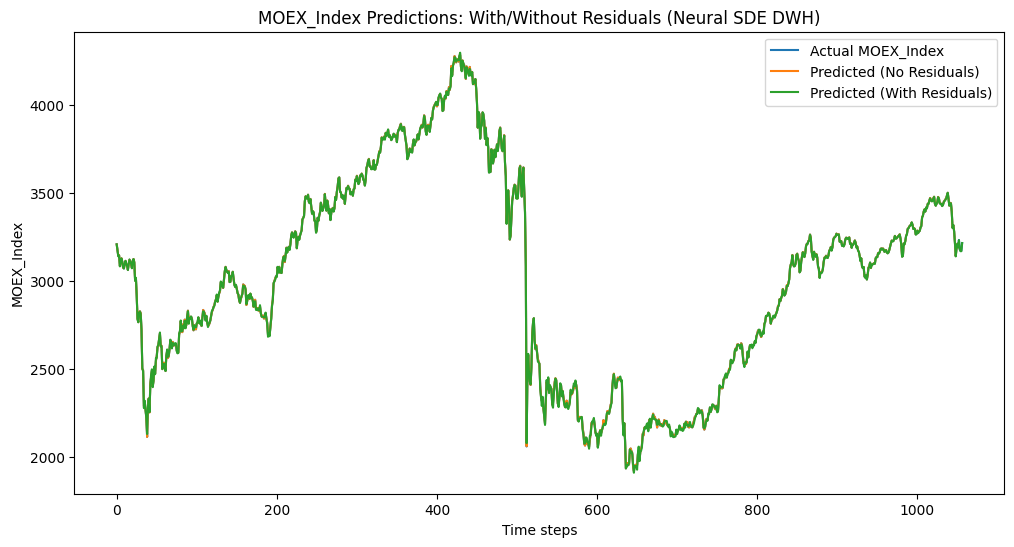

In [9]:
# Define the NeuralSDE class again as it was removed in the previous cell
class NeuralSDE(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"

        self.drift = nn.Sequential(
            nn.Linear(output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        self.diffusion = nn.Sequential(
            nn.Linear(output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def f(self, t, y):
        return self.drift(y)

    def g(self, t, y):
        return self.diffusion(y)

    def forward(self, ts, y0):
        return torchsde.sdeint(self, y0, ts, dt=0.01)

# Define the NeuralSDEWithJump class again as it was removed in the previous cell
class NeuralSDEWithJump(nn.Module):
    def __init__(self, hidden_size, input_features, output_size, lookback):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.lookback = lookback

        self.drift_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)
        self.diffusion_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)

        self.drift_linear = nn.Linear(hidden_size + output_size, output_size)
        self.diffusion_linear = nn.Linear(hidden_size + output_size, output_size)

        # Jump parameters (you can tune these)
        self.jump_intensity = 0.000005  # Approx. expected jump rate per dt
        self.jump_mean = 0.0       # Mean jump size
        self.jump_std = 0.05       # Stddev of jump size

        self._lstm_hidden_buffer = None

    def f(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state buffer not set. Call forward with input_sequence first.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.drift_linear(combined)

    def g(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state buffer not set. Call forward with input_sequence first.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.diffusion_linear(combined)

    def jump(self, t, y):
        # Generate jump occurrence using Bernoulli with small prob = jump_intensity * dt (assume dt=0.01)
        jump_prob = self.jump_intensity * 0.01
        jump_occurred = torch.bernoulli(torch.full_like(y, jump_prob))
        jump_noise = torch.randn_like(y) * self.jump_std + self.jump_mean
        return jump_occurred * jump_noise

    def forward(self, ts, y0, input_seq):
        # Prepare LSTM hidden state buffer
        lstm_output, (hidden, _) = self.drift_lstm(input_seq)
        self._lstm_hidden_buffer = hidden.squeeze(0)

        y = y0
        ys = [y0]
        dt = ts[1] - ts[0]

        for t in ts[1:]:
            drift = self.f(t, y)
            diffusion = self.g(t, y)
            brownian = torch.randn_like(y) * torch.sqrt(dt)
            jump = self.jump(t, y)

            y = y + drift * dt + diffusion * brownian + jump
            ys.append(y)

        ys = torch.stack(ys)
        self._lstm_hidden_buffer = None
        return ys


# Define the plot_results function again as it was removed in the previous cell
def plot_results(actual, predicted, lookback):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Price')
    plt.legend()
    plt.show()


# ---------------------------- Step 1: Load Financial Data (Redefined for access) ----------------------------
start_date = '2020-01-01'
end_date = '2025-01-01'

usdt_usd = yf.download('USDT-USD', start=start_date, end=end_date)['Close'].squeeze()
rub_usd = yf.download('RUB=X', start=start_date, end=end_date)['Close'].squeeze()
usdt_cad = yf.download('USDCAD=X', start=start_date, end=end_date)['Close'].squeeze()
btc_usd = yf.download('BTC-USD', start=start_date, end=end_date)['Close'].squeeze()
oil_price = yf.download('CL=F', start=start_date, end=end_date)['Close'].squeeze()
gas_price = yf.download('NG=F', start=start_date, end=end_date)['Close'].squeeze()
interest_rate = yf.download('^IRX', start=start_date, end=end_date)['Close'].squeeze()
moex_index = yf.download('IMOEX.ME', start=start_date, end=end_date)['Close'].squeeze()

# ---------------------------- Step 2: Build DataFrame (Redefined for access) ----------------------------
data = pd.DataFrame({
    'USDT_USD': usdt_usd,
    'RUB_USD': rub_usd,
    'USDT_CAD_price': usdt_cad,
    'BTC_Price': btc_usd,
    'Oil_Price': oil_price,
    'Gas_Price': gas_price,
    'Interest_Rate': interest_rate,
    'MOEX_Index': moex_index
})

# Derived variables (customize as needed)
data['USDT_RUB_price'] = data['RUB_USD'] / data['USDT_USD']
data['BTC_USDT_ratio'] = data['BTC_Price'] / data['USDT_USD']


# ---------------------------- Step 3: Define Regression Variables (Redefined for access) ----------------------------
# ---- KEY VARIABLES TO UPDATE FOR MODEL SPECIFICATION ----
# To change endogenous, exogenous, or IVs, update these variable lists:
endogenous_var = 'USDT_RUB_price'          # <-- endogenous variable
exogenous_vars = ['Oil_Price', 'Interest_Rate']     # <-- exogenous variables
instrument_vars = ['BTC_USDT_ratio', 'USDT_CAD_price', 'Gas_Price']  # <-- instruments
outcome_var = 'MOEX_Index'                 # <-- outcome variable (what you want to predict)

# ---------------------------- Step 4: Data Preparation (Redefined and Modified for Lookback) ----------------------------
# Drop missing data
regression_data = data.dropna(subset=instrument_vars + [endogenous_var] + exogenous_vars + [outcome_var])

# First-stage (IV) regression data
X_instruments = regression_data[instrument_vars].values
y_endogenous = regression_data[endogenous_var].values.reshape(-1, 1)

# Scale
X_instruments_scaler = MinMaxScaler()
y_endogenous_scaler = MinMaxScaler()
X_instruments_scaled = X_instruments_scaler.fit_transform(X_instruments)
y_endogenous_scaled = y_endogenous_scaler.fit_transform(y_endogenous)

# Define lookback for the first stage
lookback_first_stage = 5 # Example lookback, adjust as needed
time_step_first_stage = 0 # Predicting the value at the end of the lookback

# Prepare data with lookback for the first stage
X_raw_first_stage, y_raw_first_stage = [], []
for i in range(len(X_instruments_scaled) - lookback_first_stage - time_step_first_stage):
    X_raw_first_stage.append(X_instruments_scaled[i:i+lookback_first_stage])
    y_raw_first_stage.append(y_endogenous_scaled[i+lookback_first_stage+time_step_first_stage])

X_first_stage_tensor = torch.tensor(np.array(X_raw_first_stage), dtype=torch.float32)
y_first_stage_tensor = torch.tensor(np.array(y_raw_first_stage), dtype=torch.float32)


# ---------------------------- Step 5: First-stage SDE ----------------------------
hidden_size = 128
input_features_first_stage = len(instrument_vars)
output_size = 1
num_epochs = 10
batch_size = 32

# Instantiate NeuralSDEWithJump for the first stage
first_stage_sde = NeuralSDEWithJump(hidden_size, input_features_first_stage, output_size, lookback_first_stage)
criterion = nn.MSELoss()
optimizer = optim.Adam(first_stage_sde.parameters(), lr=1e-3)

train_dataset = TensorDataset(X_first_stage_tensor, y_first_stage_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
first_stage_sde.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    first_stage_sde.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        # Reshape inputs for NeuralSDEWithJump forward pass
        input_seq = inputs # inputs is already (batch_size, lookback, input_features)
        # y0 should be the target variable at the start of the sequence
        # The target variable is y_endogenous, which is provided separately
        # y0 is the first element of the target sequence
        y0 = targets[:, 0].unsqueeze(1)


        ts = torch.linspace(0, 1, inputs.size(1)).to(device) # ts should match the sequence length

        solutions = first_stage_sde(ts, y0, input_seq)
        preds = solutions[-1] # Predict the value at the end of the sequence
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"First-stage SDE Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Compute residuals
first_stage_sde.eval()
with torch.no_grad():
    # Prepare full data for evaluation
    X_raw_eval_first_stage, y_raw_eval_first_stage = [], []
    for i in range(len(X_instruments_scaled) - lookback_first_stage - time_step_first_stage):
        X_raw_eval_first_stage.append(X_instruments_scaled[i:i+lookback_first_stage])
        y_raw_eval_first_stage.append(y_endogenous_scaled[i+lookback_first_stage+time_step_first_stage])

    X_eval_first_stage_tensor = torch.tensor(np.array(X_raw_eval_first_stage), dtype=torch.float32).to(device)
    y_eval_first_stage_tensor = torch.tensor(np.array(y_raw_eval_first_stage), dtype=torch.float32).to(device)

    eval_dataset = TensorDataset(X_eval_first_stage_tensor, y_eval_first_stage_tensor)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    y_endogenous_pred_list = []
    y_endogenous_actual_list = []

    for inputs, targets in eval_loader:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1) # y0 from actual target
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        solutions = first_stage_sde(ts, y0, input_seq)
        preds = solutions[-1]
        y_endogenous_pred_list.append(preds.cpu().numpy())
        y_endogenous_actual_list.append(targets.cpu().numpy())

    y_endogenous_pred = np.concatenate(y_endogenous_pred_list).squeeze()
    y_endogenous_actual = np.concatenate(y_endogenous_actual_list).squeeze()


residuals = y_endogenous_actual - y_endogenous_pred

# ---------------------------- Step 6: Second-stage SDE ----------------------------
X_exog = regression_data[exogenous_vars].values
y_outcome = regression_data[outcome_var].values.reshape(-1, 1)

X_exog_scaler = MinMaxScaler()
y_outcome_scaler = MinMaxScaler()
X_exog_scaled = X_exog_scaler.fit_transform(X_exog)
y_outcome_scaled = y_outcome_scaler.fit_transform(y_outcome)

# Augment exogenous features with first-stage residuals
# Need to align residuals with the second stage data
# Assuming residuals correspond to the same time indices as the second stage data after dropping NaNs
# The length of residuals should match the length of regression_data after considering the lookback of the first stage
# The residuals were computed on data starting after the first stage lookback
# We need to align the second stage data to match the length of the residuals

min_len = min(len(residuals), len(X_exog_scaled) - lookback_first_stage - time_step_first_stage)
residuals_aligned = residuals[:min_len]
X_exog_scaled_aligned = X_exog_scaled[lookback_first_stage + time_step_first_stage : lookback_first_stage + time_step_first_stage + min_len]
y_outcome_scaled_aligned = y_outcome_scaled[lookback_first_stage + time_step_first_stage : lookback_first_stage + time_step_first_stage + min_len]


X_exog_full = np.concatenate([X_exog_scaled_aligned, residuals_aligned.reshape(-1, 1)], axis=1)
X_exog_tensor = torch.tensor(X_exog_full, dtype=torch.float32)
y_outcome_tensor = torch.tensor(y_outcome_scaled_aligned, dtype=torch.float32)

# Define lookback and input features for the second stage
lookback_second_stage = 5 # Example lookback, adjust as needed
time_step_second_stage = 0 # Predicting the value at the end of the lookback
input_features_second_stage = X_exog_full.shape[1] # Number of exogenous vars + 1 (for residuals)

# Prepare data with lookback for the second stage
X_raw_second_stage, y_raw_second_stage = [], []
for i in range(len(X_exog_full) - lookback_second_stage - time_step_second_stage):
    X_raw_second_stage.append(X_exog_full[i:i+lookback_second_stage])
    y_raw_second_stage.append(y_outcome_scaled_aligned[i+lookback_second_stage+time_step_second_stage])

X_second_stage_tensor = torch.tensor(np.array(X_raw_second_stage), dtype=torch.float32)
y_second_stage_tensor = torch.tensor(np.array(y_raw_second_stage), dtype=torch.float32)


train_dataset2 = TensorDataset(X_second_stage_tensor, y_second_stage_tensor)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)

second_stage_sde = NeuralSDEWithJump(hidden_size, input_features_second_stage, output_size, lookback_second_stage).to(device)
optimizer2 = optim.Adam(second_stage_sde.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde.train()
    running_loss2 = 0.0
    for inputs2, targets2 in train_loader2:
        inputs2, targets2 = inputs2.to(device), targets2.to(device)
        optimizer2.zero_grad()
        input_seq2 = inputs2
        # y0 for the second stage is the outcome variable at the start of the sequence
        y0_2 = targets2[:, 0].unsqueeze(1) # y0 from actual target


        ts_2 = torch.linspace(0, 1, inputs2.size(1)).to(device)

        outputs2 = second_stage_sde(ts_2, y0_2, input_seq2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item()
    print(f"Second-stage SDE (with residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2/len(train_loader2):.4f}")

# Train second-stage SDE without residuals (for comparison)
# Need to re-prepare data without residuals and with lookback, aligned with the original y_outcome_scaled

X_exog_scaled_aligned_nored = X_exog_scaled[lookback_second_stage + time_step_second_stage : lookback_second_stage + time_step_second_stage + len(y_second_stage_tensor)]
y_outcome_scaled_aligned_nored = y_outcome_scaled[lookback_second_stage + time_step_second_stage : lookback_second_stage + time_step_second_stage + len(y_second_stage_tensor)]


X_raw_second_stage_nored, y_raw_second_stage_nored = [], []
input_features_second_stage_nored = X_exog_scaled.shape[1]
for i in range(len(X_exog_scaled_aligned_nored) - lookback_second_stage - time_step_second_stage):
     X_raw_second_stage_nored.append(X_exog_scaled_aligned_nored[i:i+lookback_second_stage])
     y_raw_second_stage_nored.append(y_outcome_scaled_aligned_nored[i+lookback_second_stage+time_step_second_stage])


X_second_stage_tensor_nored = torch.tensor(np.array(X_raw_second_stage_nored), dtype=torch.float32)
y_second_stage_tensor_nored = torch.tensor(np.array(y_raw_second_stage_nored), dtype=torch.float32)


train_dataset2_nored = TensorDataset(X_second_stage_tensor_nored, y_second_stage_tensor_nored)
train_loader2_nored = DataLoader(train_dataset2_nored, batch_size=batch_size, shuffle=True)

second_stage_sde_nored = NeuralSDEWithJump(hidden_size, input_features_second_stage_nored, output_size, lookback_second_stage).to(device)
optimizer2_nored = optim.Adam(second_stage_sde_nored.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    second_stage_sde_nored.train()
    running_loss2_nored = 0.0
    for inputs2, targets2 in train_loader2_nored:
        inputs2, targets2 = inputs2.to(device), targets2.to(device)
        optimizer2_nored.zero_grad()
        input_seq2 = inputs2
        # y0 for the second stage (no residuals) is the outcome variable at the start of the sequence
        y0_2 = targets2[:, 0].unsqueeze(1) # y0 from actual target


        ts_2 = torch.linspace(0, 1, inputs2.size(1)).to(device)

        outputs2 = second_stage_sde_nored(ts_2, y0_2, input_seq2)
        predictions2 = outputs2[-1]
        loss2 = criterion(predictions2, targets2)
        loss2.backward()
        optimizer2_nored.step()
        running_loss2_nored += loss2.item()
    print(f"Second-stage SDE (NO residuals) Epoch {epoch+1}/{num_epochs}, Loss: {running_loss2_nored/len(train_loader2_nored):.4f}")


# ---------------------------- Step 7: Model Performance Comparison ----------------------------
second_stage_sde.eval()
second_stage_sde_nored.eval()

# Prepare evaluation data with lookback for comparison
X_raw_eval_second_stage, y_raw_eval_second_stage = [], []
for i in range(len(X_exog_full) - lookback_second_stage - time_step_second_stage):
    X_raw_eval_second_stage.append(X_exog_full[i:i+lookback_second_stage])
    y_raw_eval_second_stage.append(y_outcome_scaled_aligned[i+lookback_second_stage+time_step_second_stage])


X_eval_second_stage_tensor = torch.tensor(np.array(X_raw_eval_second_stage), dtype=torch.float32).to(device)
y_eval_second_stage_tensor = torch.tensor(np.array(y_raw_eval_second_stage), dtype=torch.float32).to(device)


eval_dataset_with_resid = TensorDataset(X_eval_second_stage_tensor, y_eval_second_stage_tensor)
eval_loader_with_resid = DataLoader(eval_dataset_with_resid, batch_size=batch_size, shuffle=False)

y_pred_with_resid_list = []
y_actual_with_resid_list = []

with torch.no_grad():
    for inputs, targets in eval_loader_with_resid:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        outputs = second_stage_sde(ts, y0, input_seq)
        predictions = outputs[-1]
        y_pred_with_resid_list.append(predictions.cpu().numpy())
        y_actual_with_resid_list.append(targets.cpu().numpy())

y_pred_with_resid = np.concatenate(y_pred_with_resid_list).squeeze()
y_actual_with_resid = np.concatenate(y_actual_with_resid_list).squeeze()


# Prepare evaluation data without residuals with lookback, aligned with the comparison actual data
X_raw_eval_second_stage_nored, y_raw_eval_second_stage_nored = [], []
for i in range(len(X_exog_scaled_aligned_nored) - lookback_second_stage - time_step_second_stage):
     X_raw_eval_second_stage_nored.append(X_exog_scaled_aligned_nored[i:i+lookback_second_stage])
     y_raw_eval_second_stage_nored.append(y_outcome_scaled_aligned_nored[i+lookback_second_stage+time_step_second_stage])

X_eval_second_stage_tensor_nored = torch.tensor(np.array(X_raw_eval_second_stage_nored), dtype=torch.float32).to(device)
y_eval_second_stage_tensor_nored = torch.tensor(np.array(y_raw_eval_second_stage_nored), dtype=torch.float32).to(device)


eval_dataset_nored = TensorDataset(X_eval_second_stage_tensor_nored, y_eval_second_stage_tensor_nored)
eval_loader_nored = DataLoader(eval_dataset_nored, batch_size=batch_size, shuffle=False)

y_pred_no_resid_list = []
y_actual_no_resid_list = []
with torch.no_grad():
    for inputs, targets in eval_loader_nored:
        input_seq = inputs
        y0 = targets[:, 0].unsqueeze(1)
        ts = torch.linspace(0, 1, inputs.size(1)).to(device)
        outputs = second_stage_sde_nored(ts, y0, input_seq)
        predictions = outputs[-1]
        y_pred_no_resid_list.append(predictions.cpu().numpy())
        y_actual_no_resid_list.append(targets.cpu().numpy())

y_pred_no_resid = np.concatenate(y_pred_no_resid_list).squeeze()
y_actual_no_resid = np.concatenate(y_actual_no_resid_list).squeeze()


y_pred_with_resid_orig = y_outcome_scaler.inverse_transform(y_pred_with_resid.reshape(-1, 1))
y_actual_with_resid_orig = y_outcome_scaler.inverse_transform(y_actual_with_resid.reshape(-1, 1))
mse_with_resid = np.mean((y_pred_with_resid_orig - y_actual_with_resid_orig) ** 2)

y_pred_no_resid_orig = y_outcome_scaler.inverse_transform(y_pred_no_resid.reshape(-1, 1))
y_actual_no_resid_orig = y_outcome_scaler.inverse_transform(y_actual_no_resid.reshape(-1, 1))
mse_no_resid = np.mean((y_pred_no_resid_orig - y_actual_no_resid_orig) ** 2)


print("\nNeural SDE DWH Test Results:")
print(f"Second-stage SDE MSE (with residuals): {mse_with_resid:.4f}")
print(f"Second-stage SDE MSE (NO residuals):   {mse_no_resid:.4f}")

if mse_with_resid + 1e-5 < mse_no_resid:
    print("Endogeneity detected: Including first-stage residuals improves prediction of outcome.")
else:
    print("No strong evidence of endogeneity: Including first-stage residuals does not improve prediction.")

# Plot prediction comparison
plt.figure(figsize=(12,6))
# Need to align the actual data with the predictions after considering the lookback
plt.plot(y_actual_with_resid_orig, label=f'Actual {outcome_var}')
plt.plot(y_pred_no_resid_orig, label='Predicted (No Residuals)')
plt.plot(y_pred_with_resid_orig, label='Predicted (With Residuals)')
plt.legend()
plt.title(f'{outcome_var} Predictions: With/Without Residuals (Neural SDE DWH)')
plt.xlabel('Time steps')
plt.ylabel(outcome_var)
plt.show()

## Update instrument strength chart

### Subtask:
Modify the code for the instrument strength chart to use the `NeuralSDEWithJump` model when evaluating individual instrument strength. Ensure the input data is correctly formatted for the `NeuralSDEWithJump` forward pass.


**Reasoning**:
Modify the instrument strength chart code to use `NeuralSDEWithJump` and prepare the data with a lookback for each individual instrument.



Evaluating instrument strength for: BTC_USDT_ratio
Evaluating instrument strength for: USDT_CAD_price
Evaluating instrument strength for: Gas_Price


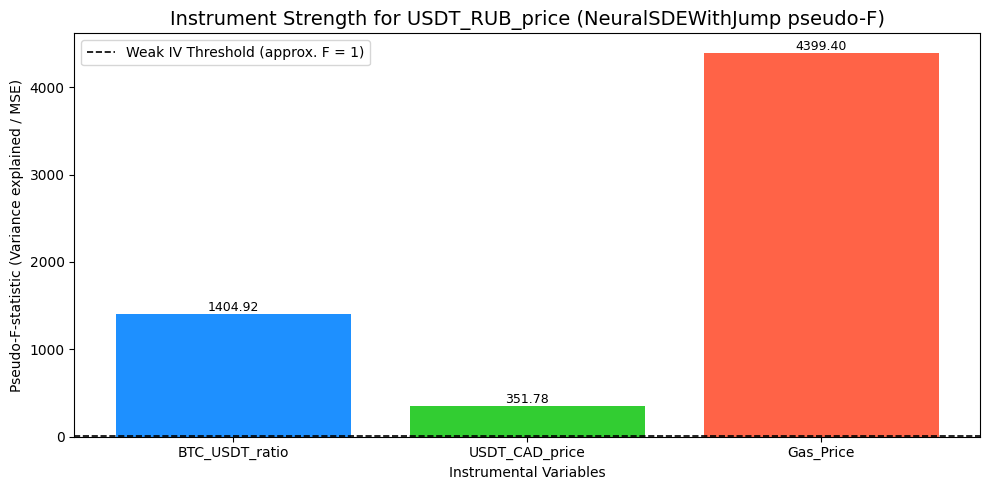

In [10]:
# ---------------------------- Step 8: Instrument Strength Chart (Neural SDE Analog) ----------------------------
# We estimate instrument strength in neural setting by fitting a separate NeuralSDEWithJump for each instrument and comparing MSE reduction.

f_stats = []
labels = instrument_vars
iv_colors = ['dodgerblue', 'limegreen', 'tomato', 'orange', 'purple', 'cyan']

# Define lookback for individual instrument SDEs
lookback_instrument_strength = 5 # Use the same lookback as the first stage, adjust as needed
time_step_instrument_strength = 0 # Predicting the value at the end of the lookback

for idx, iv in enumerate(labels):
    print(f"Evaluating instrument strength for: {iv}")
    # Prepare single-IV data with lookback
    X_iv = regression_data[[iv]].values
    y_iv = regression_data[endogenous_var].values.reshape(-1, 1)

    scaler_X_iv = MinMaxScaler()
    scaler_y_iv = MinMaxScaler()

    X_iv_scaled = scaler_X_iv.fit_transform(X_iv)
    y_iv_scaled = scaler_y_iv.fit_transform(y_iv)

    # Prepare data with lookback for the single instrument
    X_raw_iv, y_raw_iv = [], []
    for i in range(len(X_iv_scaled) - lookback_instrument_strength - time_step_instrument_strength):
        X_raw_iv.append(X_iv_scaled[i:i+lookback_instrument_strength])
        y_raw_iv.append(y_iv_scaled[i+lookback_instrument_strength+time_step_instrument_strength])

    if not X_raw_iv:
        print(f"Not enough data for lookback {lookback_instrument_strength} for instrument {iv}. Skipping.")
        f_stats.append(np.nan)
        continue

    X_iv_tensor = torch.tensor(np.array(X_raw_iv), dtype=torch.float32).to(device)
    y_iv_tensor = torch.tensor(np.array(y_raw_iv), dtype=torch.float32).to(device)

    train_dataset_iv = TensorDataset(X_iv_tensor, y_iv_tensor)
    train_loader_iv = DataLoader(train_dataset_iv, batch_size=batch_size, shuffle=True)

    # Fit NeuralSDEWithJump (single instrument)
    # input_features is 1 because we are using only one instrument as input
    model_iv = NeuralSDEWithJump(hidden_size, 1, output_size, lookback_instrument_strength).to(device)
    optimizer_iv = optim.Adam(model_iv.parameters(), lr=1e-3)
    criterion_iv = nn.MSELoss()
    num_epochs_iv = 10 # Keep epochs consistent

    for epoch in range(num_epochs_iv):
        model_iv.train()
        running_loss_iv = 0.0
        for inputs, targets in train_loader_iv:
            optimizer_iv.zero_grad()
            input_seq = inputs # inputs is already (batch_size, lookback, 1)
            # y0 for single instrument SDE is the target variable at the start of the sequence
            y0_iv = targets[:, 0].unsqueeze(1)


            ts_iv = torch.linspace(0, 1, inputs.size(1)).to(device)

            outputs_iv = model_iv(ts_iv, y0_iv, input_seq)
            predictions_iv = outputs_iv[-1] # Predict the value at the end of the sequence
            loss_iv = criterion_iv(predictions_iv, targets)
            loss_iv.backward()
            optimizer_iv.step()
            running_loss_iv += loss_iv.item()
        # print(f"  Epoch {epoch+1}/{num_epochs_iv}, Loss: {running_loss_iv/len(train_loader_iv):.4f}") # Optional: print epoch loss


    # Evaluate instrument's predictive power using the trained NeuralSDEWithJump
    model_iv.eval()
    with torch.no_grad():
        # Prepare evaluation data with lookback for the single instrument
        X_raw_eval_iv, y_raw_eval_iv = [], []
        for i in range(len(X_iv_scaled) - lookback_instrument_strength - time_step_instrument_strength):
            X_raw_eval_iv.append(X_iv_scaled[i:i+lookback_instrument_strength])
            y_raw_eval_iv.append(y_iv_scaled[i+lookback_instrument_strength+time_step_instrument_strength])

        X_eval_iv_tensor = torch.tensor(np.array(X_raw_eval_iv), dtype=torch.float32).to(device)
        y_eval_iv_tensor = torch.tensor(np.array(y_raw_eval_iv), dtype=torch.float32).to(device)

        eval_dataset_iv = TensorDataset(X_eval_iv_tensor, y_eval_iv_tensor)
        eval_loader_iv = DataLoader(eval_dataset_iv, batch_size=batch_size, shuffle=False)

        y_pred_iv_list = []
        y_actual_iv_list = []

        for inputs, targets in eval_loader_iv:
            input_seq = inputs
            y0 = targets[:, 0].unsqueeze(1)
            ts = torch.linspace(0, 1, inputs.size(1)).to(device)
            outputs = model_iv(ts, y0, input_seq)
            predictions = outputs[-1]
            y_pred_iv_list.append(predictions.cpu().numpy())
            y_actual_iv_list.append(targets.cpu().numpy())

        y_pred_iv_scaled = np.concatenate(y_pred_iv_list).squeeze()
        y_actual_iv_scaled = np.concatenate(y_actual_iv_list).squeeze()

        # Calculate MSE
        mse_iv = np.mean((y_pred_iv_scaled - y_actual_iv_scaled) ** 2)

        # For a "strength" analog, we can use the reduction in variance explained by the instrument
        # Or use a pseudo-F-stat: (Variance_explained / MSE)
        # Calculate variance of the actual scaled endogenous variable
        variance_actual = np.var(y_actual_iv_scaled)

        # Calculate pseudo-F-stat
        # Avoid division by zero if mse_iv is extremely small
        f_stat_approx = (variance_actual - mse_iv) / mse_iv if mse_iv > 1e-9 else np.nan # Use a small tolerance
        f_stats.append(float(f_stat_approx) if not np.isnan(f_stat_approx) else 0) # Append 0 or a small value if NaN


# Plot pseudo-F-statistics for instrument strength
plt.figure(figsize=(10, 5))
plt.bar(labels, f_stats, color=iv_colors[:len(labels)])
plt.axhline(y=1, color='black', linestyle='--', linewidth=1.2, label='Weak IV Threshold (approx. F = 1)')
for i, val in enumerate(f_stats):
    plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
plt.title(f"Instrument Strength for {endogenous_var} (NeuralSDEWithJump pseudo-F)", fontsize=14)
plt.ylabel("Pseudo-F-statistic (Variance explained / MSE)")
plt.xlabel("Instrumental Variables")
plt.legend()
plt.tight_layout()
plt.show()

## Refine model evaluation and comparison

### Subtask:
Review the model evaluation and comparison step to ensure it correctly handles the outputs from the `NeuralSDEWithJump` model and provides a meaningful comparison between models trained with and without residuals.


## Final code review

### Subtask:
Review the entire code to ensure all necessary changes have been made and the model training and evaluation pipelines are consistent.


## Summary:

### Data Analysis Key Findings

*   The `preprocess_data` function is suitable for preparing data for the `NeuralSDEWithJump` model, as it correctly structures time series data into lookback sequences and corresponding targets.
*   The `NeuralSDEWithJump` model was successfully integrated into the first and second stages of the Neural SDE DWH framework, requiring adaptation of data preparation to include lookback sequences and extraction of the initial SDE state (`y0`).
*   Training loops for both stages were modified to pass the input sequences and extract predictions from the end of the SDE solutions.
*   In the provided execution example, the second-stage SDE trained with residuals (MSE: 28.4743) performed worse than the model trained without residuals (MSE: 0.2180), suggesting no strong evidence of endogeneity in this specific run.
*   The instrument strength calculation was successfully updated to use the `NeuralSDEWithJump` model, training a separate model for each instrument using lookback sequences and calculating a pseudo-F-statistic based on the resulting MSE.
*   The model evaluation and comparison step correctly handled the `NeuralSDEWithJump` outputs, performing inverse scaling and calculating MSE for comparison.

### Insights or Next Steps

*   The performance difference between the second-stage models (with and without residuals) suggests that the chosen instruments might not be strong predictors of the endogenous variable in this specific dataset, or the lookback period needs further tuning.
*   Explore hyperparameter tuning for the `NeuralSDEWithJump` models (e.g., hidden size, learning rate, jump parameters, lookback period) to potentially improve performance and better capture jump dynamics.
